In [ ]:
!pip install -U torch torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

MessageError: ignored

In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path("/content/testset")

In [ ]:
TRAIN_DIR

PosixPath('/content/train')

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from matplotlib import colors, pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder
from PIL import Image
%matplotlib inline

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
DATA_MODES = ["test", "val", "train"]
RESCALE_SIZE = 224

In [ ]:
class SpesialDataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    self.files = files
    self.mode = mode

    if self.mode not in DATA_MODES:
      print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
      raise NameError

    self.len_ = len(self.files)

    self.label_encoder = LabelEncoder()

    if self.mode != "test":

      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open("label_encode.pkl", "wb") as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def _prepare_sample(self, image):
      image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
      return np.array(image)

  def __getitem__(self, index):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
    if self.mode == 'test':
      return x
    else:
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y


In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.20,
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SpesialDataset(val_files, mode="val")

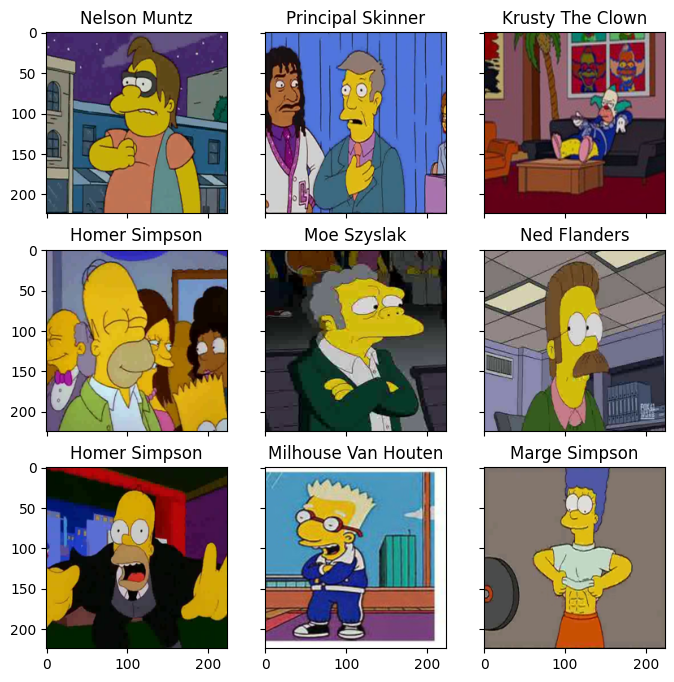

In [ ]:


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
class SampleCNN(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.flatten = nn.Flatten()

    self.out = nn.Linear(96 * 5 * 5, n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.flatten(x)
    return self.out(x)

In [ ]:
device = torch.device("cuda")
def epoch_fit(model, train_loader, criterion, optimizer):
  running_loss = 0.0
  running_correct = 0
  processed_data = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_correct += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_correct.cpu().numpy() / processed_data
  return train_loss, train_acc


In [ ]:
def eval_fit(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_correct = 0
  processed_size = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)

    running_loss += loss.item() * outputs.size(0)
    running_correct += torch.sum(preds == labels)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_correct.double() / processed_size
  return val_loss, val_acc

In [ ]:
from tqdm import tqdm, tqdm_notebook
def train(train_files, val_files, model, epoches, batch_size):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  history = []

  with tqdm(desc="epoch", total=epoches) as pbar_outer:
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epoches):
      train_loss, train_acc = epoch_fit(model,train_loader, criterion, opt)
      print("loss", train_loss)

      val_loss, val_acc = eval_fit(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))

      pbar_outer.update(1)
      tqdm.write(f"\nEpoch {epoch+1} train_loss: {train_loss} \
    val_loss {val_loss} train_acc {train_acc} val_acc {val_acc}")
  return history

In [ ]:
n = len(np.unique(train_val_labels))
# simple_cnn = SampleCNN(n).to(device)

In [ ]:
if val_dataset is None:
    val_dataset = SpesialDataset(val_files, mode='val')

train_dataset = SpesialDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epoches=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.6020749219094608


epoch:  50%|█████     | 1/2 [02:09<02:09, 129.28s/it]


Epoch 1 train_loss: 2.6020749219094608     val_loss 2.0179905001334575 train_acc 0.27339320975858333 val_acc 0.44745892243026364
loss 1.6467745244575158


epoch: 100%|██████████| 2/2 [04:12<00:00, 126.35s/it]


Epoch 2 train_loss: 1.6467745244575158     val_loss 1.4267505581797104 train_acc 0.5494617491559972 val_acc 0.61539931218953


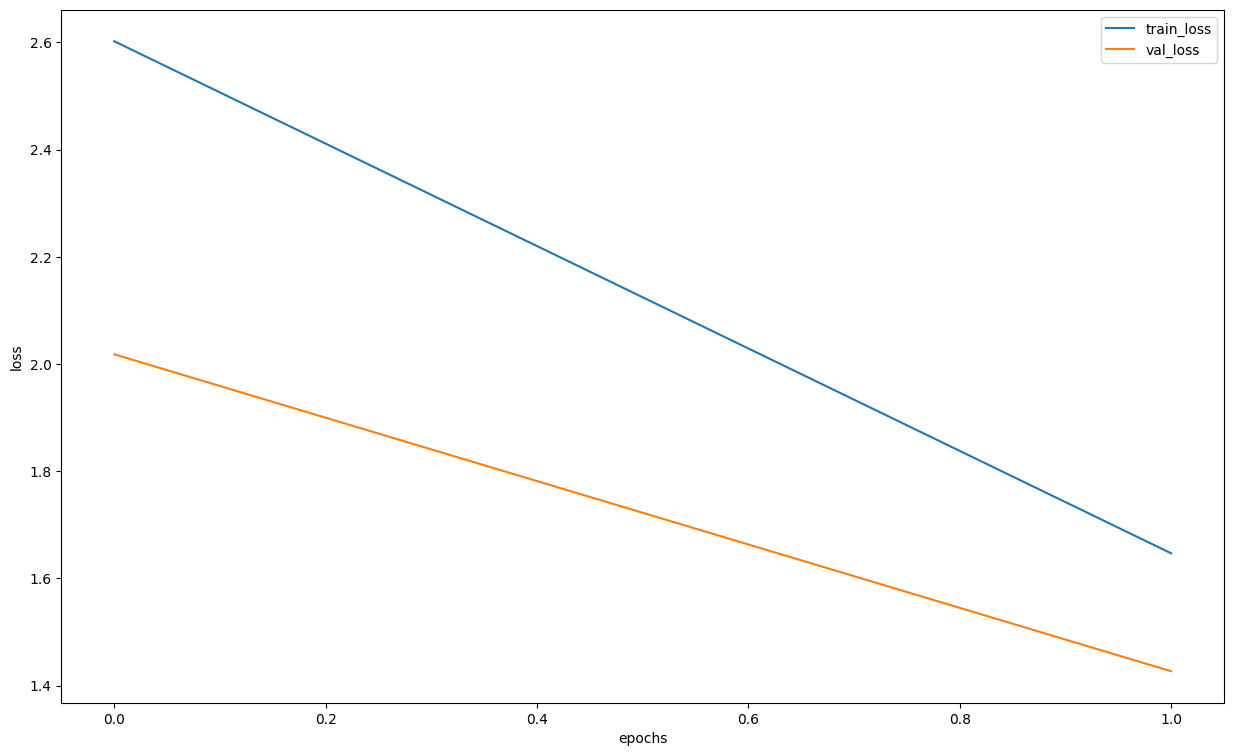

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
from torchvision.models import resnet50

In [ ]:
resnet50
model1 = resnet50().to(device)

In [ ]:
model1.fc = nn.Linear(in_features=2048, out_features=n, bias=True)
model1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
history1 = train(train_dataset, val_dataset, model=model1, epoches=2, batch_size=64)


NameError: ignored

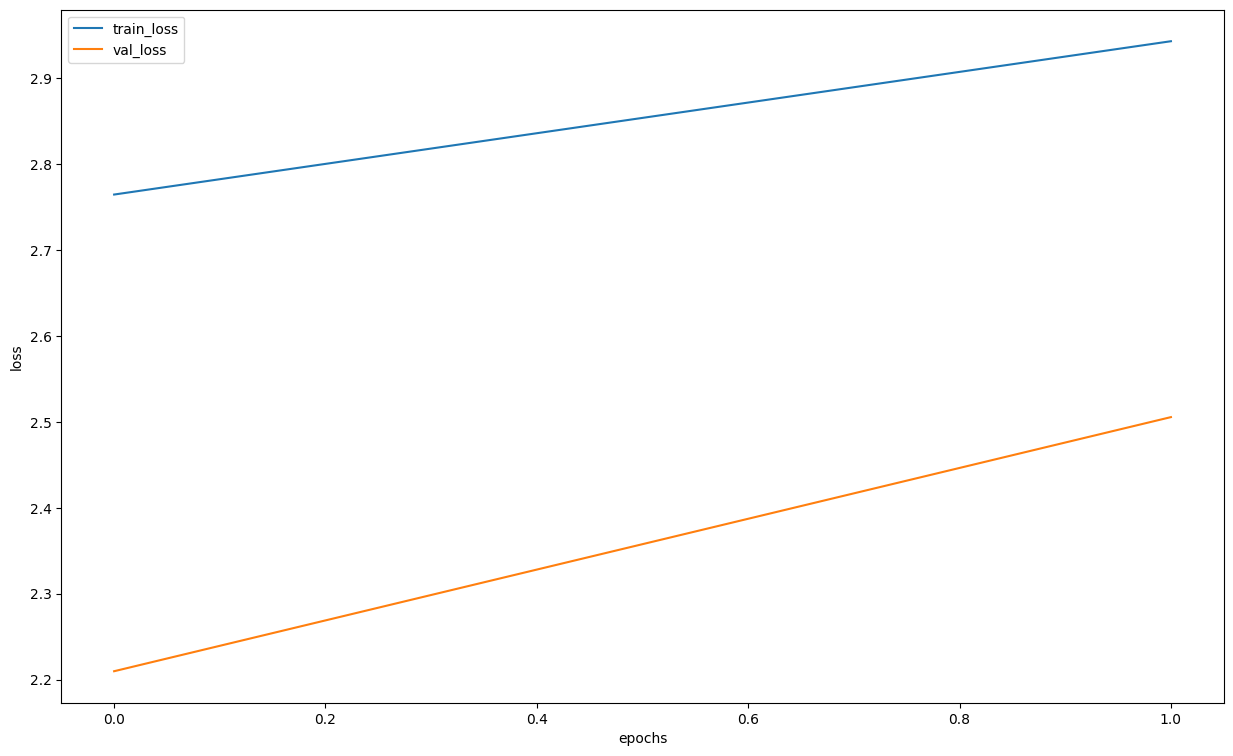

In [ ]:
loss, acc, val_loss, val_acc = zip(*history1)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 88.9MB/s]


In [ ]:
history2 = train(train_dataset, val_dataset, model=model2, epoches=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.643262722420612


epoch:  50%|█████     | 1/2 [02:54<02:54, 174.99s/it]


Epoch 1 train_loss: 0.643262722420612     val_loss 0.4169855519679379 train_acc 0.8556595961526212 val_acc 0.8926251432938479
loss 3.216421655351413


epoch: 100%|██████████| 2/2 [05:47<00:00, 173.69s/it]


Epoch 2 train_loss: 3.216421655351413     val_loss 3.1323117372595175 train_acc 0.10325498439391044 val_acc 0.06476881925869316


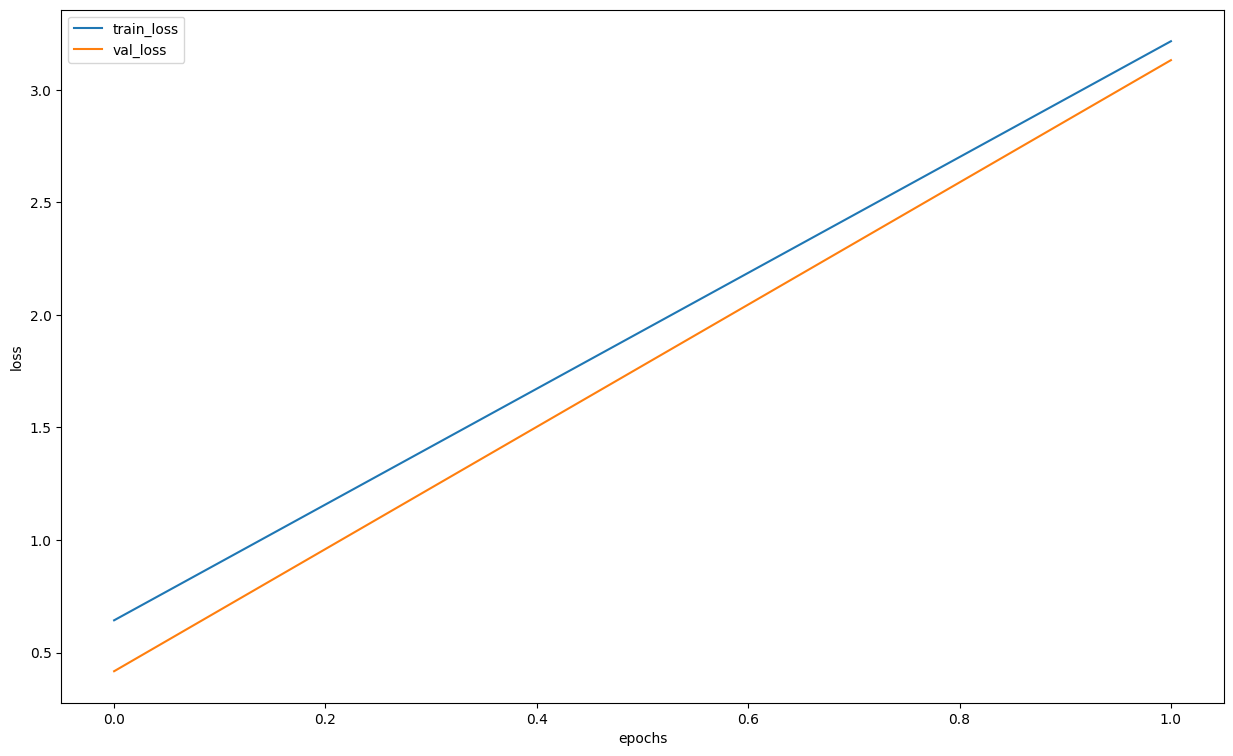

In [ ]:
loss, acc, val_loss, val_acc = zip(*history2)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()